# HOT Region Classification

The following cell defines file names and parameters.

- **kmer_length** denotes the number of basepairs considered when converting sequences to kmers
- **sampling_percentage** denotes the percentage of sequences that will be used to build the model
- **seed** is for reproducing results

In [15]:
input_hot = 'hot_regions_01_all.fa'
input_lot = 'lot_regions_01_all.fa'
kmer_length = 3
sampling_percentage = 1
seed = 35

The following cell includes all imports used in this notebook.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

The following cell parses the input Fasta files for HOT and LOT sequences and builds lists of the sequences.

In [2]:
with open(input_hot) as fasta_file:
    hot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        hot_sequences.append(sequence)

with open(input_lot) as fasta_file:
    lot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        lot_sequences.append(sequence)

The following cell creates dataframes for the HOT and LOT sequences with the following labels:
- *1* for HOT sequences (positive class)
- *0* for LOT sequences (negative class)

The sequence distribution is then displayed.

In [16]:
df_hot = pd.DataFrame(hot_sequences, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences, columns=['sequence'])
df_lot['label'] = 0

temp = pd.concat([df_hot, df_lot])
temp.label.value_counts()

0    3028
1    1505
Name: label, dtype: int64

The following cell performs downsampling on the majority class using **seed** and aggregates the sequences inside *df_resample*. The number of samples in each class are then displayed.

In [4]:
if df_hot.shape[0] < df_lot.shape[0]:
    df_minority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_majority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)
else:
    df_majority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_minority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)

df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=seed)

df_resample = pd.concat([df_majority_downsampled, df_minority])
df_resample.label.value_counts()

0    1505
1    1505
Name: label, dtype: int64

The following cell defines a helper function that returns the extracted kmers from the sequences, which is used to replace the HOT and LOT sequences by their extracted kmers in list format. The updated dataframe is displayed below.

In [5]:
def kmers(seq, length):
    return [seq[i:i+length].lower() for i in range(len(seq)-length+1)]

df_resample['kmers'] = df_resample.apply(lambda a: kmers(a['sequence'], kmer_length), axis=1)
df_resample.drop('sequence',axis=1, inplace=True)
df_resample = df_resample.reset_index()
df_resample.drop('index', axis=1, inplace=True)
df_resample.head()

,label,kmers
0,0,"[tga, gag, agg, ggg, gga, gaa, aaa, aaa, aag, ..."
1,0,"[ctc, tct, ctg, tgc, gct, ctg, tgc, gct, ctt, ..."
2,0,"[ctg, tgc, gca, caa, aag, agg, gga, gag, agc, ..."
3,0,"[ttc, tcg, cga, gac, act, ctt, ttt, ttt, ttt, ..."
4,0,"[ttc, tct, ctc, tca, cag, agc, gcc, cca, cat, ..."


The following cell converts each list of kmers into sentences to be fed into CountVectorizer. The labels are also saved to be fed into the classifers later on.

In [6]:
kmer_sentences = list(df_resample['kmers'])
for x in range(len(kmer_sentences)):
    kmer_sentences[x] = ' '.join(kmer_sentences[x])

labels = df_resample.iloc[:,0].values

The following cell counts kmer occurences in the sentences using CountVectorizer and performs Min-Max normalization on the vectors. The normalized kmer distributions are displayed below in lexicographic order.

In [7]:
c = CountVectorizer(ngram_range=(1,1))
x = c.fit_transform(kmer_sentences)

x_normalized = normalize(x, norm='l1')
scaler = MaxAbsScaler()
x_scaled = scaler.fit_transform(x_normalized)
scaled_df_unsorted = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
scaled_df = scaled_df_unsorted.reindex(sorted(scaled_df_unsorted.columns), axis=1)
scaled_df.head()

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tcg,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt
0,0.033285,0.122857,0.225397,0.328255,0.346028,0.000000,0.434501,0.199643,0.203277,0.241497,...,0.079112,0.186327,0.328908,0.367347,0.107819,0.013310,0.260073,0.431429,0.090318,0.416183
1,0.000000,0.133837,0.296403,0.269135,0.228685,0.000000,0.347797,0.195737,0.175925,0.152002,...,0.000000,0.190575,0.335372,0.371594,0.038173,0.000000,0.263080,0.392775,0.104651,0.420994
2,0.042695,0.230326,0.165212,0.642670,0.118362,0.173647,0.145394,0.157592,0.260748,0.034419,...,0.253696,0.119503,0.109693,0.033657,0.207452,0.051218,0.381259,0.138351,0.126385,0.305056
3,0.091885,0.260888,0.133333,0.310005,0.541298,0.093427,0.338980,0.296761,0.155878,0.111111,...,0.109196,0.157167,0.136196,0.181087,0.173624,0.000000,0.358974,0.233944,0.101998,0.246193
4,0.000000,0.078621,0.187512,0.459926,0.307058,0.000000,0.534346,0.178862,0.338220,0.178583,...,0.000000,0.310017,0.240790,0.218288,0.029899,0.022145,0.216360,0.256367,0.081968,0.461640


The following cell builds and tests the Support Vector Classifier on the kmer distribution data. The accuracy, classification report, and confusion matrix are displayed below.

Accuracy using SVM = 0.9424778761061947
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       228
           1       0.95      0.94      0.94       224

    accuracy                           0.94       452
   macro avg       0.94      0.94      0.94       452
weighted avg       0.94      0.94      0.94       452



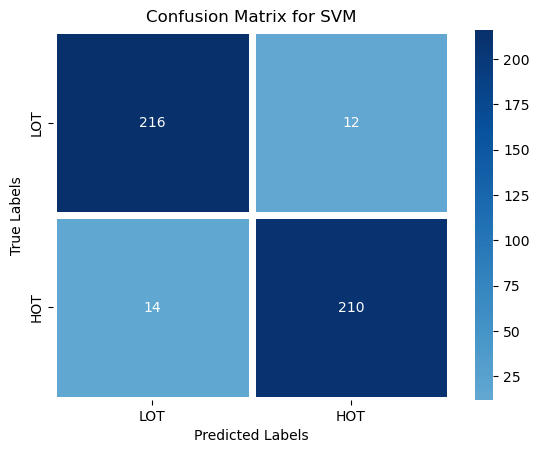

In [14]:
clf = SVC(C=1.0, kernel='linear', gamma=0.05)

X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, labels, test_size = 0.15, random_state=seed)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print('Accuracy using SVM =', accuracy_score(Y_test, Y_pred))

print(classification_report(Y_test, Y_pred))

cf = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for SVM')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

The following cell builds and tests a cross validated Support Vector Classifier on the kmer distribution data with 5 folds. Average accuracy, precision, recall, and f-1 scores are displayed below.

In [10]:
# scores = cross_validate(clf, x, labels, cv=5, scoring=['accuracy','precision','recall','f1'])
# print("Cross validation produces an average of:")
# print("\t%0.2f accuracy" % scores['test_accuracy'].mean())
# print("\t%0.2f precision" % scores['test_precision'].mean())
# print("\t%0.2f recall" % scores['test_recall'].mean())
# print("\t%0.2f f1" % scores['test_f1'].mean())

The following cell builds and tests the Random Forest Classifier on the kmer distribution data. The model's accuracy and classification report are displayed below.

In [12]:
clf = RandomForestClassifier(n_estimators = 300)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print('Accuracy using Random Forest =', accuracy_score(Y_test, Y_pred))

print(classification_report(Y_test, Y_pred))

Accuracy using Random Forest = 0.9469026548672567
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       228
           1       0.95      0.94      0.95       224

    accuracy                           0.95       452
   macro avg       0.95      0.95      0.95       452
weighted avg       0.95      0.95      0.95       452



The following cell builds and tests a cross validated Random Forest Classifier on the kmer distribution data with 5 folds. Average accuracy, precision, recall, and f-1 scores are displayed below.

In [13]:
# scores = cross_validate(clf, x, labels, cv=5, scoring=['accuracy','precision','recall','f1'])
# print("Cross validation produces an average of:")
# print("\t%0.2f accuracy" % scores['test_accuracy'].mean())
# print("\t%0.2f precision" % scores['test_precision'].mean())
# print("\t%0.2f recall" % scores['test_recall'].mean())
# print("\t%0.2f f1" % scores['test_f1'].mean())